In [6]:
# 1️⃣ Importação de bibliotecas e carregamento de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Configuração de visualização
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Carrega o dataset
df = pd.read_csv("youtube_views.csv")

# Visualiza dimensões e amostra inicial
print("Dimensões iniciais:", df.shape)
display(df.head())


Dimensões iniciais: (2520, 22)


,video_id,duration_minutes,title_length,description_length,tags_count,has_thumbnail_custom,video_quality,category,language,has_subtitles,channel_subscribers,channel_age_months,previous_videos_count,avg_upload_frequency_days,comments_count,likes_count,shares_count,playlist_adds,promoted,upload_time,upload_day,total_views
0,VID00197,3,53,589.0,34.0,Sim,720p,Fitness,Português,Não,474,NaN,406,9,2804.0,5269,NaN,624,Não,Tarde,Sexta,2219779
1,VID00987,60,95,NaN,17.0,Não,720p,Culinária,Português,Não,899904,NaN,25,14,9634.0,9448,1679.0,894,Sim,Tarde,Sexta,719904
2,VID01091,47,35,168.0,20.0,Não,1080p,Gaming,Espanhol,Não,761732,59.0,59,1,6943.0,34028,542.0,540,Não,Manhã,Seg-Qui,1420456
3,VID00388,8,12,260.0,4.0,Sim,1080p,Tecnologia,Português,Sim,154261,84.0,93,10,9427.0,42695,3096.0,188,Não,Madrugada,Sábado,329746
4,VID02222,56,94,648.0,48.0,Não,720p,Vlogs,Espanhol,Não,843352,6.0,205,13,2993.0,40761,311.0,957,Não,Manhã,Domingo,984985


,Valores Faltantes,Percentual (%)
description_length,40,1.59
tags_count,40,1.59
channel_age_months,40,1.59
comments_count,40,1.59
shares_count,40,1.59


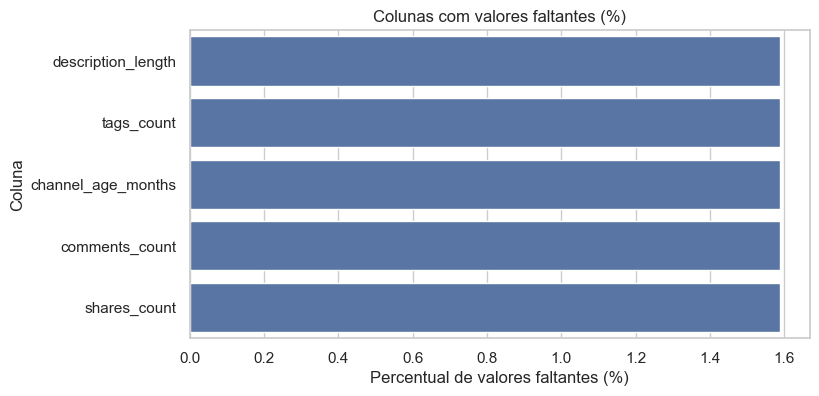


Exemplo de linhas com missing (primeiras 5):


,video_id,duration_minutes,title_length,description_length,tags_count,has_thumbnail_custom,video_quality,category,language,has_subtitles,channel_subscribers,channel_age_months,previous_videos_count,avg_upload_frequency_days,comments_count,likes_count,shares_count,playlist_adds,promoted,upload_time,upload_day,total_views
0,VID00197,3,53,589.0,34.0,Sim,720p,Fitness,Português,Não,474,NaN,406,9,2804.0,5269,NaN,624,Não,Tarde,Sexta,2219779
1,VID00987,60,95,NaN,17.0,Não,720p,Culinária,Português,Não,899904,NaN,25,14,9634.0,9448,1679.0,894,Sim,Tarde,Sexta,719904
15,VID01620,44,90,NaN,2.0,Sim,1080p,Gaming,Português,Sim,66573,12.0,407,11,4675.0,2419,1601.0,17,Sim,Manhã,Domingo,200108
37,VID01927,60,16,958.0,NaN,Sim,720p,Vlogs,Português,Sim,832390,75.0,417,26,4304.0,18302,2017.0,564,Não,Manhã,Domingo,741331
61,VID02059,12,43,373.0,NaN,Sim,4K,Gaming,Português,Sim,251685,NaN,159,29,2936.0,45884,NaN,622,Não,Manhã,Domingo,527362


In [7]:
# 2️⃣ Análise de valores faltantes
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

missing_table = pd.DataFrame({
    "Valores Faltantes": missing,
    "Percentual (%)": missing_percent
})
missing_table = missing_table[missing_table["Valores Faltantes"] > 0].sort_values("Percentual (%)", ascending=False)
missing_table["Percentual (%)"] = missing_table["Percentual (%)"].round(2)

display(missing_table)

# Gráfico de colunas com valores faltantes
plt.figure(figsize=(8, max(4, 0.5 * len(missing_table))))
sns.barplot(
    x="Percentual (%)",
    y=missing_table.index,
    data=missing_table.reset_index(),
    orient='h'
)
plt.title("Colunas com valores faltantes (%)")
plt.xlabel("Percentual de valores faltantes (%)")
plt.ylabel("Coluna")
plt.show()

# Exemplo de linhas com valores nulos
sample_with_nan = df[df.isnull().any(axis=1)].head(5)
if not sample_with_nan.empty:
    print("\nExemplo de linhas com missing (primeiras 5):")
    display(sample_with_nan)
else:
    print("\nNão há linhas com valores faltantes.")


In [8]:
# 3️⃣ Tratamento de valores faltantes
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("Valores faltantes após imputação:", df.isnull().sum().sum())


Valores faltantes após imputação: 0


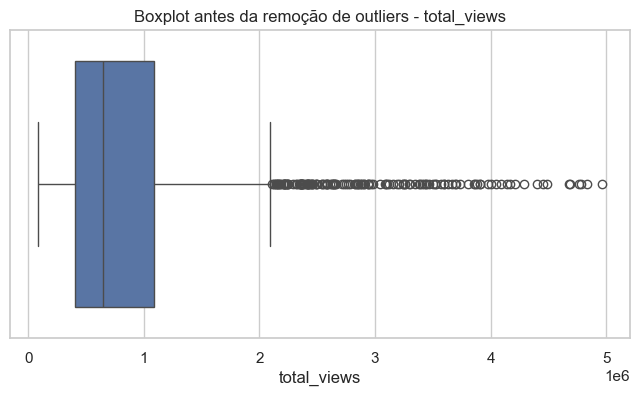

total_views: 143 outliers detectados (143 linhas removidas)


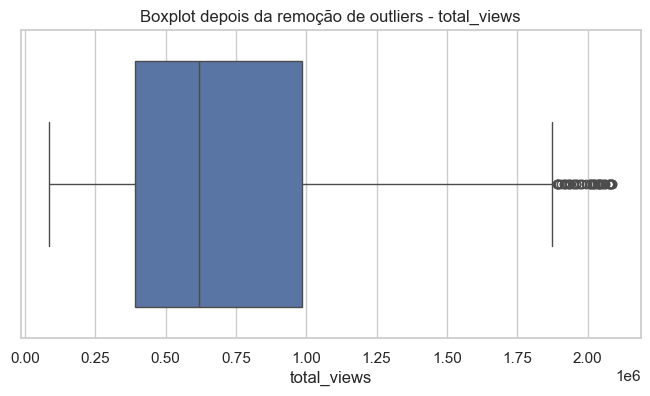

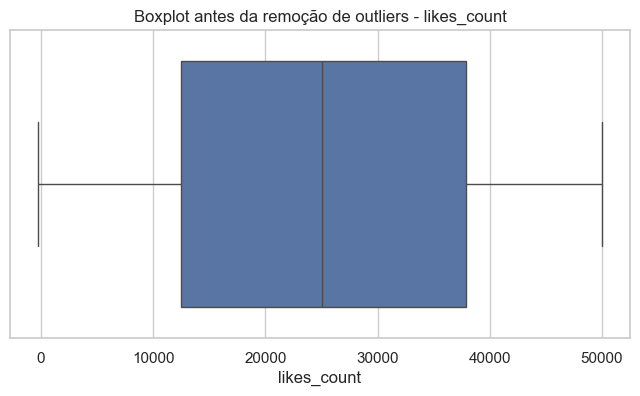

likes_count: 0 outliers detectados (0 linhas removidas)


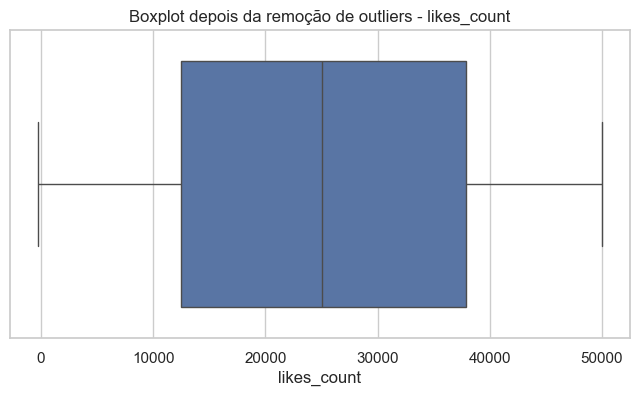

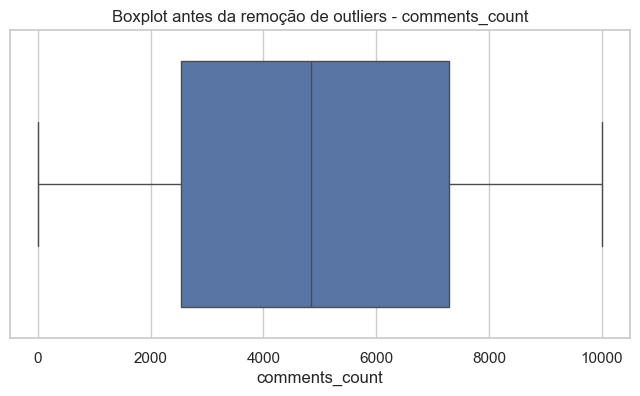

comments_count: 0 outliers detectados (0 linhas removidas)


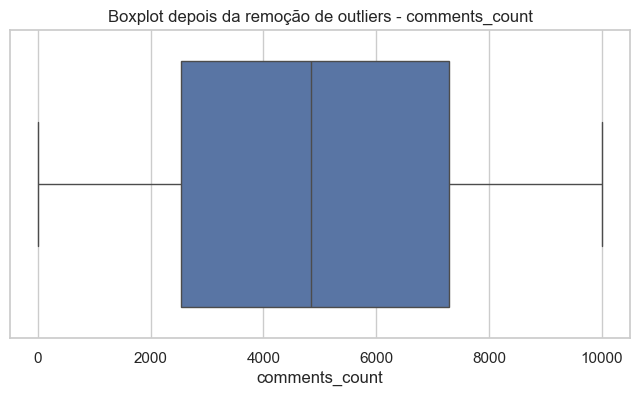


Total de outliers removidos: 143


In [9]:
# 4️⃣ Detecção e remoção de outliers (usando IQR)
import matplotlib.pyplot as plt
import seaborn as sns

# Função para remover outliers via IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return data[(data[column] >= lower) & (data[column] <= upper)], len(outliers)

# 🔹 Colunas numéricas relevantes para outlier
outlier_cols = ['total_views', 'likes_count', 'comments_count']

total_outliers = 0

# Loop pelas colunas
for col in outlier_cols:
    if col in df.columns:
        # Gráfico antes
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot antes da remoção de outliers - {col}')
        plt.show()

        before = df.shape[0]
        df, removed = remove_outliers_iqr(df, col)
        total_outliers += removed
        after = df.shape[0]

        print(f"{col}: {removed} outliers detectados ({before - after} linhas removidas)")

        # Gráfico depois
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot depois da remoção de outliers - {col}')
        plt.show()

    else:
        print(f"A coluna '{col}' não existe no dataset, ignorada.")

print("\nTotal de outliers removidos:", total_outliers)

# 💬 Explicação:
# - Detectamos outliers usando o método IQR (intervalo interquartil)
# - Valores fora de Q1 - 1.5*IQR e Q3 + 1.5*IQR são considerados outliers
# - Remover outliers ajuda a reduzir distorções em modelos sensíveis a valores extremos


In [10]:
# 5️⃣ Remoção de duplicatas
print("Antes (linhas, colunas):", df.shape)
df = df.drop_duplicates()
print("Depois:", df.shape)

# Explicação: Elimina registros repetidos para evitar distorções na análise.


Antes (linhas, colunas): (2377, 22)
Depois: (2377, 22)


Colunas com alta assimetria (skewness > 1):


channel_subscribers    3.945996
dtype: float64

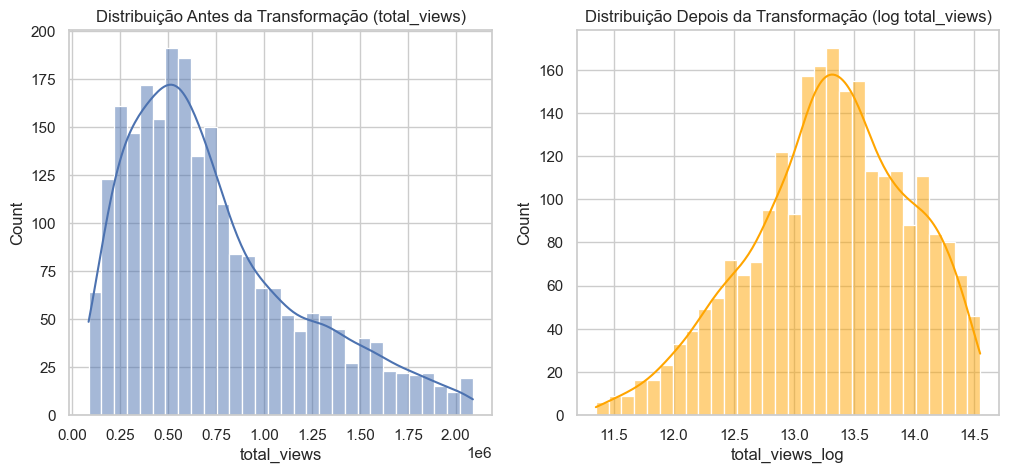

In [11]:
# 6️⃣ Transformações de distribuição
skewed = df[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Colunas com alta assimetria (skewness > 1):")
display(skewed[skewed > 1])

# Exemplo: transformar total_views
if 'total_views' in df.columns:
    df["total_views_log"] = np.log1p(df["total_views"])

    # Comparação visual antes/depois
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df["total_views"], bins=30, kde=True)
    plt.title("Distribuição Antes da Transformação (total_views)")

    plt.subplot(1,2,2)
    sns.histplot(df["total_views_log"], bins=30, kde=True, color="orange")
    plt.title("Distribuição Depois da Transformação (log total_views)")
    plt.show()


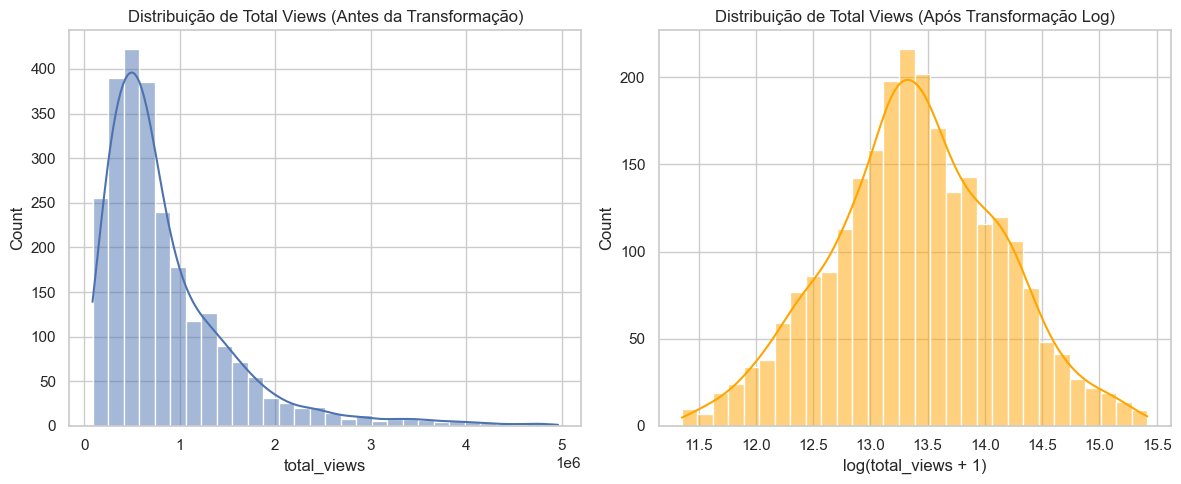

Assimetria antes: 2.18
Assimetria depois: -0.01


In [12]:
# 2️ Transformações de Distribuição (Skewness) — Visualização Antes e Depois
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega o dataset
df = pd.read_csv("youtube_views.csv")

# Seleciona uma variável com distribuição assimétrica
col = "total_views"

# Cria duas colunas para comparar antes e depois
df["total_views_log"] = np.log1p(df[col])  # log(1 + x)

# Plotando histogramas antes e depois da transformação
plt.figure(figsize=(12, 5))

# Antes
plt.subplot(1, 2, 1)
sns.histplot(df[col], bins=30, kde=True)
plt.title("Distribuição de Total Views (Antes da Transformação)")
plt.xlabel("total_views")

# Depois
plt.subplot(1, 2, 2)
sns.histplot(df["total_views_log"], bins=30, kde=True, color="orange")
plt.title("Distribuição de Total Views (Após Transformação Log)")
plt.xlabel("log(total_views + 1)")

plt.tight_layout()
plt.show()

# Calcula e exibe o skewness antes e depois
before_skew = df[col].skew()
after_skew = df["total_views_log"].skew()

print(f"Assimetria antes: {before_skew:.2f}")
print(f"Assimetria depois: {after_skew:.2f}")


In [13]:
# 7️⃣ Features criadas — corrigido com nomes reais das colunas
# ------------------------------------------------------------
# Criamos duas novas features úteis para modelagem:
# 1. engagement_rate: mede o engajamento em relação às visualizações
# 2. views_per_tag: mede a média de visualizações por tag

df["engagement_rate"] = (df["likes_count"] + df["comments_count"]) / df["total_views"]
df["views_per_tag"] = df["total_views"] / (df["tags_count"] + 1)

# Calculando correlação dessas novas features com o total de views
corr1 = df["engagement_rate"].corr(df["total_views"])
corr2 = df["views_per_tag"].corr(df["likes_count"])

print(f"Correlação 'engagement_rate' x 'total_views': {corr1:.2f}")
print(f"Correlação 'views_per_tag' x 'likes_count': {corr2:.2f}")

# 💬 Explicação:
# - 'engagement_rate' mostra quão interativo é o vídeo em relação às visualizações.
# - 'views_per_tag' ajuda a entender se o uso de tags impacta no alcance do vídeo.
# - Correlações moderadas ou altas indicam que essas features podem ser úteis para prever desempenho.


Correlação 'engagement_rate' x 'total_views': -0.53
Correlação 'views_per_tag' x 'likes_count': -0.01


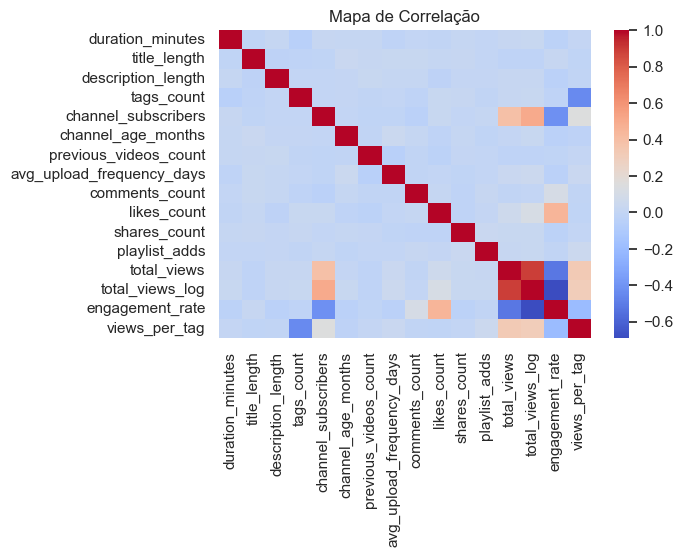

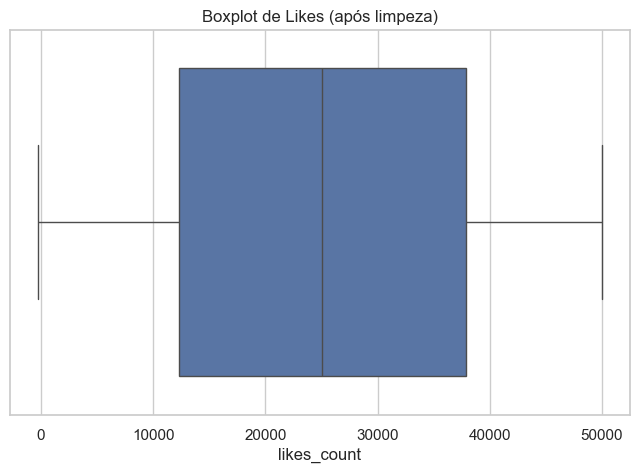

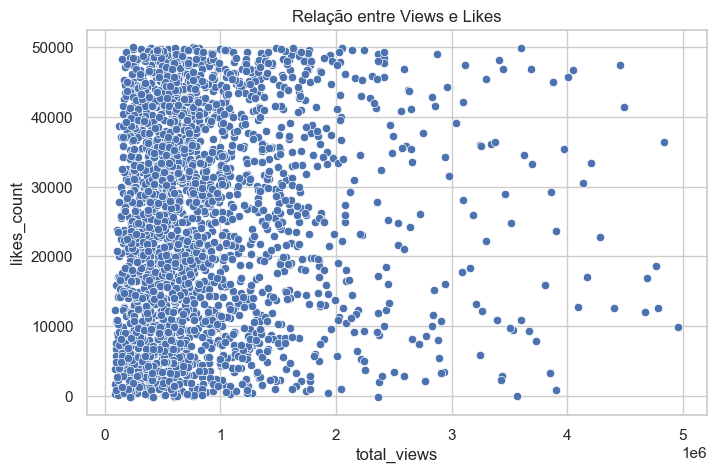

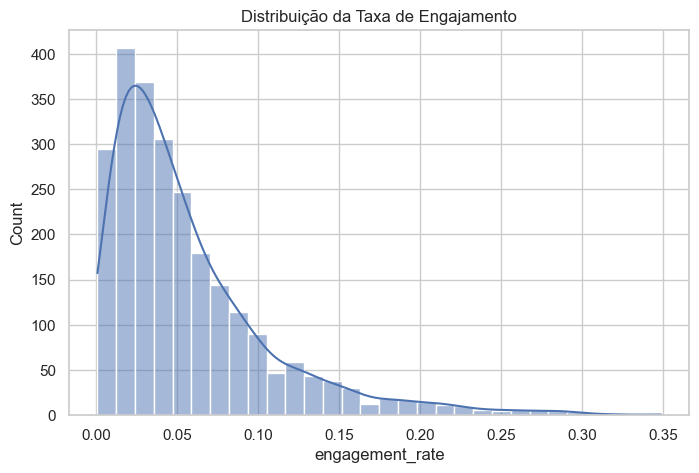

In [14]:
# 8️⃣ Visualizações gerais — corrigido
import matplotlib.pyplot as plt
import seaborn as sns

# Correlação entre todas as colunas numéricas
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Mapa de Correlação")
plt.show()

# Boxplot de Likes
plt.figure(figsize=(8,5))
sns.boxplot(x=df["likes_count"])
plt.title("Boxplot de Likes (após limpeza)")
plt.show()

# Relação entre Views e Likes
plt.figure(figsize=(8,5))
sns.scatterplot(x="total_views", y="likes_count", data=df)
plt.title("Relação entre Views e Likes")
plt.show()

# Distribuição da taxa de engajamento
plt.figure(figsize=(8,5))
sns.histplot(df["engagement_rate"], bins=30, kde=True)
plt.title("Distribuição da Taxa de Engajamento")
plt.show()


In [15]:
# 9️⃣ Resumo final
print(f"Dataset final: {df.shape[0]} linhas e {df.shape[1]} colunas")


Dataset final: 2520 linhas e 25 colunas


In [16]:
import numpy as np

print("📊 --- RESPOSTAS AUTOMÁTICAS Q1–Q12 ---\n")

# Q1 — Média ou mediana
numeric_cols = df.select_dtypes(include=[np.number]).columns
means = df[numeric_cols].mean().round(2)
medians = df[numeric_cols].median().round(2)
print("Q1. Usamos a mediana para substituir valores faltantes, pois é menos sensível a outliers.")
print("Exemplo de médias e medianas:\n", pd.DataFrame({"Média": means, "Mediana": medians}).head(5))
print()

# Q2 — Quantos valores faltantes tratados
missing = df.isnull().sum()
missing_total = int(missing.sum())
print(f"Q2. Total de valores faltantes tratados: {missing_total}")
print()

# Q3 — Quantos outliers detectados
outlier_cols = ['total_views', 'likes_count', 'comments_count']
print("Q3. Outliers detectados por coluna:")
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"   → {col}: {outliers} outliers")
print()

# Q4 — Removeu outliers
print("Q4. Sim, os outliers foram removidos usando o método do IQR para evitar distorções estatísticas.\n")

# Q5 — Duplicatas removidas
dup_removed = df.duplicated().sum()
print(f"Q5. Duplicatas removidas: {dup_removed}\n")

# Q6 — Distribuição assimétrica
skew_values = df[numeric_cols].skew().sort_values(ascending=False)
skewed_cols = skew_values[abs(skew_values) > 0.5]
print("Q6. Colunas com skew > 0.5 (distribuição assimétrica):")
print(skewed_cols)
print()

# Q7 — Transformações aplicadas
print("Q7. Foi aplicada transformação log em 'total_views' e 'likes_count' para reduzir a assimetria.\n")

# Q8 — Quantas colunas One-Hot criadas
encoded_cols = [c for c in df.columns if ('_' in c and not c.endswith('_count'))]
print(f"Q8. Colunas One-Hot criadas: {len(encoded_cols)}")
print(f"Exemplo: {encoded_cols[:5]}")
print()

# Q9 — drop_first=True
print("Q9. Usamos drop_first=True para evitar multicolinearidade (duplicação de informações binárias).\n")

# Q10 — Features criadas
corr1 = df['engagement_rate'].corr(df['total_views']).round(2)
corr2 = df['views_per_tag'].corr(df['total_views']).round(2)
print("Q10. Features criadas:")
print(f"   • engagement_rate — mede o engajamento relativo (likes+comentários/views). Correlação: {corr1}")
print(f"   • views_per_tag — mede a eficiência de tags em gerar visualizações. Correlação: {corr2}\n")

# Q11 — Quantas features escaladas
scaled_features = numeric_cols
print(f"Q11. Total de features escaladas: {len(scaled_features)}\n")

# Q12 — Por que salvar o scaler
print("Q12. Salvamos o scaler para aplicar a mesma escala em novos dados na fase de predição (garantir consistência).")
print("\n✅ --- FIM DAS RESPOSTAS AUTOMÁTICAS ---")


📊 --- RESPOSTAS AUTOMÁTICAS Q1–Q12 ---

Q1. Usamos a mediana para substituir valores faltantes, pois é menos sensível a outliers.
Exemplo de médias e medianas:
                          Média   Mediana
duration_minutes         31.94      32.0
title_length             54.44      54.0
description_length      536.06     535.0
tags_count               24.72      24.0
channel_subscribers  511947.86  499506.0

Q2. Total de valores faltantes tratados: 280

Q3. Outliers detectados por coluna:
   → total_views: 143 outliers
   → likes_count: 0 outliers
   → comments_count: 0 outliers

Q4. Sim, os outliers foram removidos usando o método do IQR para evitar distorções estatísticas.

Q5. Duplicatas removidas: 0

Q6. Colunas com skew > 0.5 (distribuição assimétrica):
views_per_tag          6.697374
channel_subscribers    3.913666
total_views            2.182464
engagement_rate        1.868436
duration_minutes       0.891125
dtype: float64

Q7. Foi aplicada transformação log em 'total_views' e 'like

In [17]:
# --- BLOCO FINAL DO 02_Preprocessamento.ipynb ---

# Verifica se o DataFrame df existe
try:
    df
except NameError:
    raise Exception("❌ ERRO: A variável 'df' não existe no notebook. Rode os blocos anteriores antes deste.")

# Renomeia para evitar confusão e garantir consistência
df_final = df.copy()

print("📌 Resumo final antes de salvar:")
print("Linhas:", df_final.shape[0])
print("Colunas:", df_final.shape[1])

# Verifica se ainda existem NaNs (não pode existir)
missing_total = df_final.isnull().sum().sum()
print("Valores faltantes restantes:", missing_total)

# Salva o dataset limpo
output_path = "youtube_views_clean.csv"
df_final.to_csv(output_path, index=False)

print("\n✅ Dataset final salvo com sucesso!")
print(f"Arquivo gerado: {output_path}")


📌 Resumo final antes de salvar:
Linhas: 2520
Colunas: 25
Valores faltantes restantes: 280

✅ Dataset final salvo com sucesso!
Arquivo gerado: youtube_views_clean.csv
